In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os
model = ChatGoogleGenerativeAI(
                model='gemini-2.0-flash',
                google_api_key=os.getenv('GOOGLE_API_KEY'),
                temperature=0,
                max_output_tokens=1000
            )

model.invoke('Hello')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--df894d1a-0c41-4d3a-8e44-54d665d55c16-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [ ]:
https://github.com/campusx-official/langgraph-tutorials/blob/main/7_review_reply_workflow.ipynb

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [3]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

In [4]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [6]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [7]:
prompt = 'What is the sentiment of the following review - The software too good'
structured_model.invoke(prompt).sentiment

'positive'

In [8]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [9]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

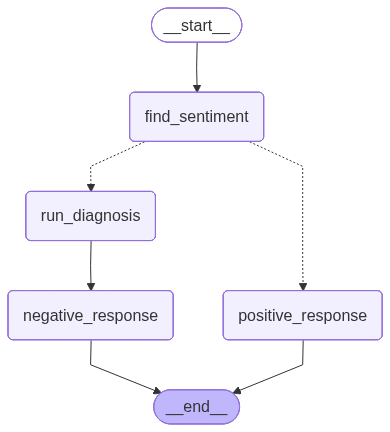

In [10]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

workflow

In [11]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details..


{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Okay, I understand you're experiencing a bug and are understandably frustrated, and that this is a high-urgency issue for you. I'm really sorry you're dealing with this. Let's get this sorted out as quickly as possible.\n\nHere's what I'm going to do to help:\n\n*   **Immediate Action:** I'm immediately escalating this issue to our development team. They're the best equipped to diagnose and fix the underlying problem.\n*   **Information Gathering:** To help them get started, could you please provide me with a few more details? (If you haven't already)\n    *   **Specific steps to reproduce the bug:** What exactly were you doing w

In [12]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")
    
structured_evaluator_llm = model.with_structured_output(TweetEvaluation)

In [13]:
from typing import Annotated
import operator
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage

class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]


def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = model.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}


def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = model.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

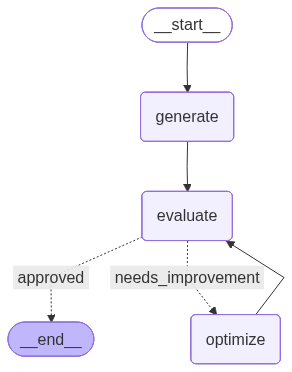

In [14]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [15]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [16]:
result

{'topic': 'srhberhb',
 'tweet': "My therapist: Just say what you're feeling.\nMe: Okay... srhberhb.\nMy therapist: ...\n#anxiety #accurate",
 'evaluation': 'approved',
 'feedback': "The tweet is concise, relatable, and humorous, effectively capturing the feeling of anxiety in a funny way. The 'srhberhb' is unexpected and adds to the humor. The hashtags are relevant and could increase visibility. It's formatted well and has good virality potential due to its relatability.",
 'iteration': 4,
 'max_iteration': 5,
 'tweet_history': ['Me trying to pronounce the name of that Icelandic volcano that grounded all the flights in 2010. #srhberhb #neverforget #travelnightmare',
  'Okay, here are a few options, playing with different angles based on the "unpronounceable" aspect and aiming for broader appeal:\n\n**Option 1 (Focus on frustration):**\n\n> My brain trying to spell "srhberhb."  It\'s like a cat walked across my keyboard. 😩 #unpronounceable #helpme\n\n**Option 2 (Emphasize the sound):**\